In [1]:
from classes.data_loader import DataLoader
from classes.quantile_model import LassoQuantileModel
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = DataLoader("data/usa.csv")

/Users/shoutianze/Desktop/F23/36490/36490-F23-Group1/classes/data_loader.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data: DataFrame = pd.read_csv(csv_file_path)


In [18]:
def monthly_evaluate(data: DataLoader, best_model: LassoQuantileModel, start: int, end: int) -> tuple[list, list]:
    """
    Give evaluation metric of a trained/fitted model on a given test/validation period
    :param data: Data loader
    :param start: period start year
    :param end: period end year
    :return: a list evaluation metric as floating number
    """
    monthly_r2_scores = []
    predictions = []
    start_year, end_year = start // 10000, end // 10000

    for year in range(start_year, end_year):
        for month in range(1, 13):
            start = int(f"{year}{month:02d}01")
            if month == 12:
                end = int(f"{year + 1}0101")
            else:
                end = int(f"{year}{month + 1:02d}01")

            df = data.slice(start, end)
            y_actual = data.get_y_quantiles(df)

            y_pred = best_model.predict(start, end)
            predictions.append(y_pred)

            # Calculate R-squared for the month
            r2 = r2_score(y_actual, y_pred)
            monthly_r2_scores.append(r2)

    return monthly_r2_scores, predictions

In [19]:
LAMBDA_VALUES = [0] + [10**i for i in range(-10, 0)]
YEAR = 10000
validation_r2s = []
test_r2s = []
lambdas = []
predictions = []

for train_start in tqdm(range(19800101, 20000101 + 2 * YEAR, YEAR)):
    train_end = train_start + 10 * YEAR
    validate_start = train_end
    validate_end = validate_start + 5 * YEAR
    test_start = validate_end
    test_end = test_start + YEAR

    # perform grid search for the best alpha and l1_ratio hyperparameters
    best_model, best_r2, best_lambda = LassoQuantileModel.validate(data, train_start, train_end,
                                                                   validate_start, validate_end,
                                                                   LAMBDA_VALUES)
    validation_r2s.append(best_r2)
    lambdas.append(best_lambda)

    # testing on an extra year of data
    test_r2, monthly_predictions = monthly_evaluate(data, best_model, test_start, test_end)
    test_r2s.extend(test_r2)
    predictions.extend(monthly_predictions)


  0%|          | 0/22 [00:00<?, ?it/s]

[0.34924151 0.40429927 0.28976121 ... 0.42861191 0.19943341 0.53996797]
[0.63255057 0.67724488 0.45984169 ... 0.57990053 0.22009615 0.6497153 ]
[0.31242123 0.32218156 0.2615474  ... 0.28603542 0.30711595 0.25935073]
[0.62657375 0.68915977 0.61256351 ... 0.43267929 0.45837105 0.61553604]


  0%|          | 0/22 [05:51<?, ?it/s]


KeyboardInterrupt: 

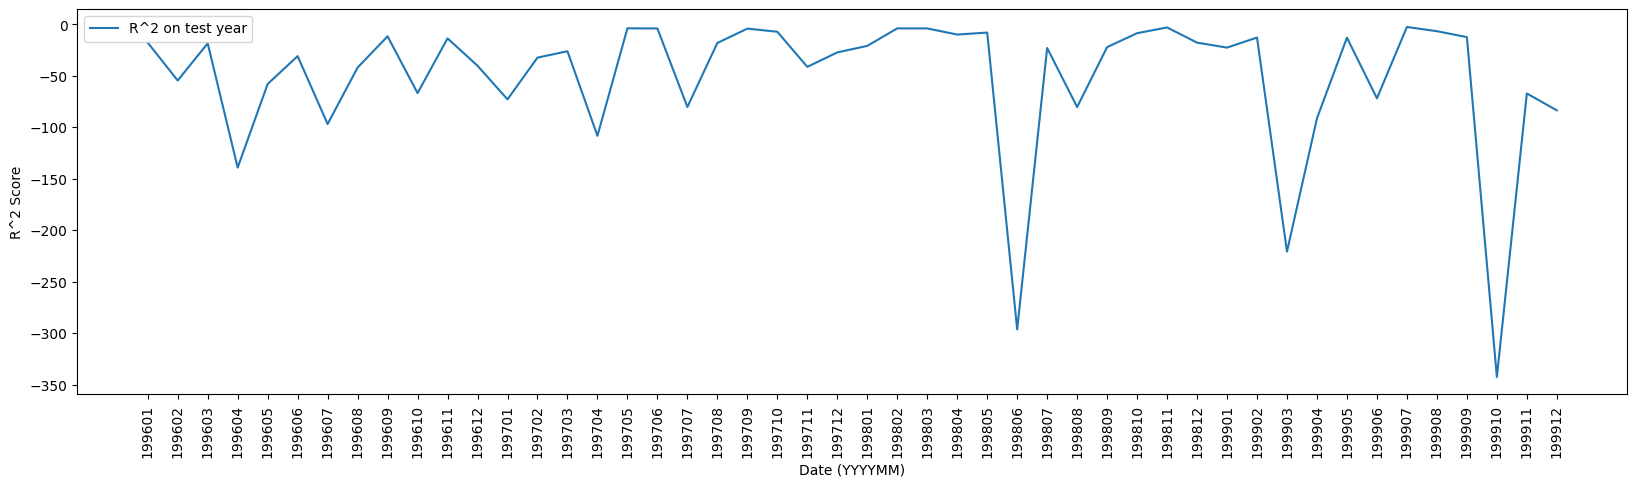

In [10]:
# evaluate r2 score by month
test_months = [year*100 + month for year in range(1996, 2018) for month in range(1, 13)]
test_months = [str(t) for t in test_months]

plt.figure(figsize=(20, 5))
plt.plot(test_months, test_r2s, label="R^2 on test year")
# plt.plot(test_months, validation_r2s, label="R^2 in validation years")
plt.xticks(rotation='vertical')
plt.xlabel('Date (YYYYMM)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()